In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

from spatgame import evolve, evolve_old, make_rgb
from meangame import MeanGamePy as MeanGame
from game import GameField as SelfGame

ModuleNotFoundError: No module named 'meangame'

In [ ]:
plt.style.use("seaborn-whitegrid")

In this game $L^2$ individual "*players*" placed in a two-dimensional spatial array.

Every individual can play one of two tactics: cooperate($\mathcal{C}$) or defect($\mathcal{D}$). At the beginning of the "game", each player has the probability of being assigned $\mathcal{C}$ with probability $p_c$ and tactics $\mathcal{D}$ otherwise.

In each round individuals "*play the game*" with 8 its neighbors and the *average cooperator*. Tables of payoffs shown below

Table: Payoffs for games with neighbors.

| payoffs | $\mathcal{D}$ | $\mathcal{C}$ |
| --------- |:-------------:|----:|
| $\mathcal{D}$ | 0 | 0 |
| $\mathcal{C}$ | $b$ | 1 |

Table: Payoffs for games with *average cooperator*

| payoffs | $\mathcal{D}$ | $\mathcal{C}$ |
| --------- |:-------------:|----:|
| $\mathcal{D}$ | 0 | 0 |
| $\mathcal{C}$ | $b f_c$ | $f_c$ |

After playing all games the site occupied either by its original owner or by one of the neighbors who scores the highest total payoff in that round.

In [ ]:
Ls = [20, 50, 100, 200, 400, 800]
bs = np.linspace(.9, 2, 60)

seeds = [5,58,4785,45895,1256,65478,854,126,42,1458,458,96324,985423,85456, 4585, 8956, 8596589,89589,74,658,84,845,9,55,489, 32,456,345,876,6, 457, 34,67,444,666, 5678, 98, 65, 389, 8765]
p_c = .9 # probability of being assigned strategy C

In [5]:
for L in Ls:
    for idx, seed in enumerate(seeds):
        np.random.seed(seed)
        np.save("fields/field_{}_{}.npy".format(L, idx), np.random.choice((0, 1), (L, L), p=(1-p_c, p_c)))

<IPython.core.display.Javascript object>


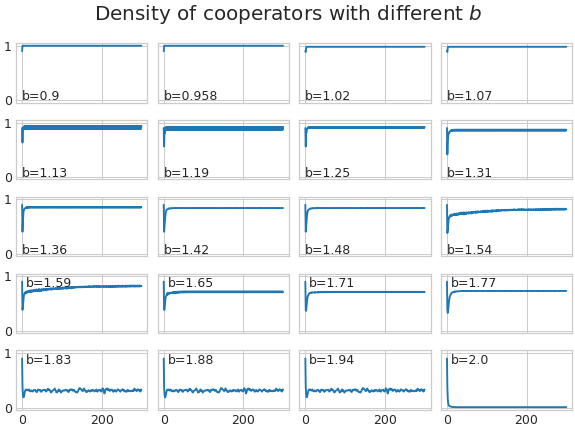

100%|██████████| 20/20 [00:14<00:00,  1.31it/s]


In [7]:
fig, axs = plt.subplots(5, 4, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Density of cooperators with different $b$', fontsize=16)
for i, b in tqdm(enumerate(np.linspace(.9, 2, 20)), total=20):
    for n in [29]:
        field = np.load("fields/field_100_{}.npy".format(n))
        d = [field.sum()/(1.*field.shape[0]**2)]
        for _ in range(int(300)):
            field = evolve_old(field, b, 1)
            d.append(field.sum()/(1.*field.shape[0]**2))
        axs[i//4, i % 4].plot(d)
        if i > 11:
            axs[i//4, i % 4].text(10, 0.8, "b={:.3}".format(b, fontsize=11))
        else:
            axs[i//4, i % 4].text(0, 0, "b={:.3}".format(b, fontsize=11))

plt.show()

In [7]:
fig.savefig("figures/f_c_for_different_b.jpg", dpi=300, quality=95)

<IPython.core.display.Javascript object>


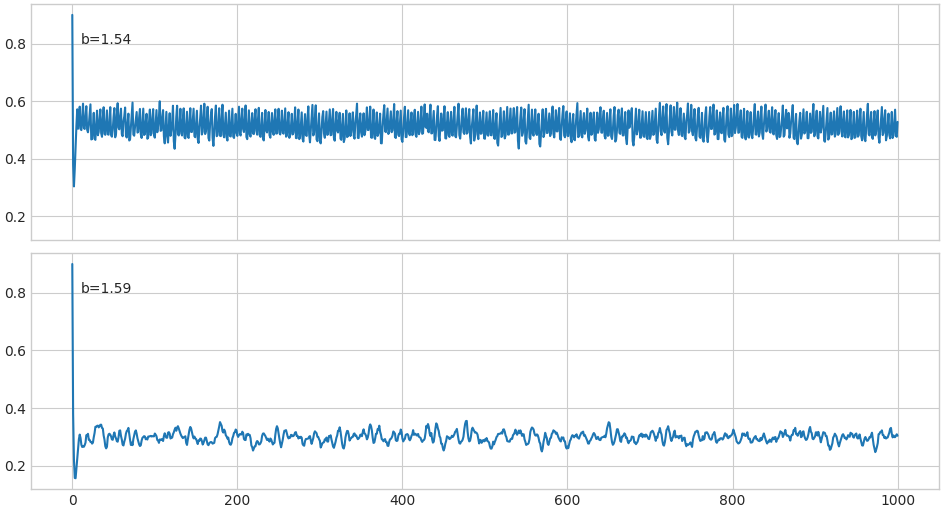

In [13]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, sharex=True, sharey=True)
for i, b in enumerate([1.54, 1.59]):
    for n in [29]:
        field = np.load("fields/field_100_{}.npy".format(n))
        d = [field.sum()/(1.*field.shape[0]**2)]
        for _ in range(int(1000)):
            field = evolve(field, b, 1)
            d.append(field.sum()/(1.*field.shape[0]**2))
        axs[i].plot(d)
        axs[i].text(10, 0.8, "b={:.3}".format(b, fontsize=11))

As shown in figure above density of the cooperators become stable after 100 steps for all $b$ and oscilates with different frequency and amplitude around mean values.

In [4]:
DROP = 1000
CALC = 2*10**3
EVERY = 1
L = 100

## Transition values(local)

The game is defined by the payoff $b$ and different behaviour is expected at different $b$

To find the values of $b$ at which transition occurs we have to understand at which values the total outcome of agent may change.


<img src="./neighbourhoods.png" alt="drawing" width="300"/>

By looking at picture above we can come up with this formuls for $b$
$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c+1}$$
for left hand side configurations

$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c}$$
for right hand side configurations

Where

$n_{c\;shared}$ - number of cooperators($\mathcal{C}$) from red region

$n_c$ - number of cooperators near cooperator(purple region)

$n_d$ - number of cooperators near defector(yellow region)

$f_c$ - density of cooperators

In [5]:
def with_agents(f_c, n_share, n_c, n_d):
    return (n_share+n_c+f_c)/(n_share+n_d+f_c+1)

def without_agents(f_c, n_share, n_c, n_d):
    return (n_share+n_c+f_c)/(n_share+n_d+f_c)

def trans_val(f_c, a, b):
    return (a+f_c)/(b+f_c)

def with_agents_old(n_share, n_c, n_d):
    return (n_share+n_c+1)/(n_share+n_d+1)

def without_agents_old(n_share, n_c, n_d):
    return (n_share+n_c+1)/(n_share+n_d)

In [6]:
f_cs = np.linspace(0, 1, 20)

In [7]:
all_transitions = []
old_transitions = []
for n_allowed in [[1, 2, 3], [1, 2, 3, 4, 5]]:
    for n_share in range(7-len(n_allowed)):
        for n_c in n_allowed:
            for n_d in n_allowed:
                all_transitions.append(with_agents(f_cs, n_share, n_c, n_d))
                old_transitions.append(with_agents_old(n_share, n_c, n_d))
                
for n_allowed in [[1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7]]:
    for n_share in range(8-len(n_allowed)):
        for n_c in n_allowed:
            for n_d in n_allowed:
                all_transitions.append(without_agents(f_cs, n_share, n_c, n_d))
                old_transitions.append(without_agents_old(n_share, n_c, n_d))

In [8]:
all_transitions = []
for a in range(0, 9):
    for b in range(0, 9):
        if b == 0:
            all_transitions.append(trans_val(np.linspace(0.00000001, 1, 20), a, b))
        else:
            all_transitions.append(trans_val(f_cs, a, b))

In [9]:
transitions = []
for i, tr in enumerate(all_transitions[:-1]):
    if not (np.square(np.array(all_transitions[i+1:]) - tr).sum(-1) < 0.0000001).any():
        transitions.append(tr)
transitions.append(all_transitions[-1])

transitions_old = []
for i, tr in enumerate(old_transitions[:-1]):
    if not (np.square(np.array(old_transitions[i+1:]) - tr) < 0.0000001).any():
        transitions_old.append(tr)
transitions_old.append(old_transitions[-1])

Values of transitions for the game with itself were taken from the article "The spatial dilemmas of evolution" by A. Novak and M. May, 1993

## Let's collect data...

In [10]:
for b_trans in transitions_old:
    if (np.square(bs - b_trans) < .0000001).any():
        bs[np.square(bs - b_trans) < .0000001] -= .005

We will begin from game described in the article "The spatial dilemmas of evolution"

In [11]:
density = []
for b in tqdm(bs):
    den = []
    field = SelfGame(L, b)
    for i in range(len(seeds)):
        d = []
        field.field = 1-np.load("fields/field_{}_{}.npy".format(L, i))
        field.evolveQ(DROP)
        for _ in range(0, CALC-DROP, EVERY):
            field.evolveQ(1)
            d.append(1-field.field.sum()/(1.*L*L))
        den.append(d)
    density.append(den)
    
np.save("data/density_of_cooperators_old_game.npy", np.asarray(density))

 22%|██▏       | 13/60 [2:51:25<11:26:53, 876.88s/it]

KeyboardInterrupt: 

In [13]:
density = []
for b in tqdm(bs):
    den = []
    for i in range(len(seeds)):
        d = []
        field = np.load("fields/field_{}_{}.npy".format(L, i))
        field = evolve_old(field, b, DROP)
        for _ in range(0, CALC-DROP, EVERY):
            field = evolve_old(field, b, EVERY)
            d.append(field.sum()/(1.*L*L))
        den.append(d)
    density.append(den)
    
np.save("data/density_of_cooperators_old_old_game.npy", np.asarray(density))

100%|██████████| 60/60 [3:17:44<00:00, 112.86s/it]   


And moves to the game that was described above

In [ ]:
game = MeanGame(L, 1.6)
density = []
for b in tqdm(bs):
    den = []
    game.b = b
    for i in range(len(seeds)):
        d = []
        game.field = np.load("fields/field_{}_{}.npy".format(L, i) )
        game.evolve(CALC//2)
        game.evolve(CALC - CALC//2)
        den.append(game.densities[DROP::EVERY].tolist())
    density.append(den)
    
np.save("data/density_of_cooperators5.npy", np.asarray(density))

 12%|█▏        | 7/60 [2:25:33<19:12:24, 1304.62s/it]

## then cook and serve it

In [11]:
def mean_without_zeros(realizations):
    means = []
    for r in realizations:
        if r.mean() > .000001:
            means.append(r.mean())
    if len(means) == 0:
        return 0, 0
    else:
        return np.asarray(means).mean(), np.asarray(means).std()

density_old_raw = np.load("data/density_of_cooperators_old_game.npy")
density_new_raw = np.load("data/density_of_cooperators.npy")
density_new_5_raw = np.load("data/density_of_cooperators5.npy")

density_old = density_old_raw.mean(axis=-1)
density_new = density_new_raw.mean(axis=-1)
density_new_5 = density_new_5_raw.mean(axis=-1)

std_o = density_old.std(axis=-1)
std_n = density_new.std(axis=-1)
std_n_5 = density_new_5.std(axis=-1)

means_o = density_old.mean(axis=-1)
means_n = density_new.mean(axis=-1)
means_n_5 = density_new_5.mean(axis=-1)

In [19]:
density_old_raw = np.load("data/density_of_cooperators_old_game.npy")
density_new_raw = np.load("data/density_of_cooperators.npy")
density_new_5_raw = np.load("data/density_of_cooperators5.npy")

density_old = density_old_raw.mean(axis=-1)
density_new = density_new_raw.mean(axis=-1)
density_new_5 = density_new_5_raw.mean(axis=-1)

means_o, std_o = [], []
std_n, std_n_5 = [], []
means_n, means_n_5 = [], []

for br in density_old:
    m, d = mean_without_zeros(br)
    means_o.append(m)
    std_o.append(d)

for br in density_new:
    m, d = mean_without_zeros(br)
    means_n.append(m)
    std_n.append(d)
    
for br in density_new_5:
    m, d = mean_without_zeros(br)
    means_n_5.append(m)
    std_n_5.append(d)
    
means_o = np.asarray(means_o)
std_o = np.asarray(std_o)
std_n = np.asarray(std_n)
std_n_5 = np.asarray(std_n_5)
means_n = np.asarray(means_n)
means_n_5 = np.asarray(means_n_5)

## Let's see what we got

<IPython.core.display.Javascript object>


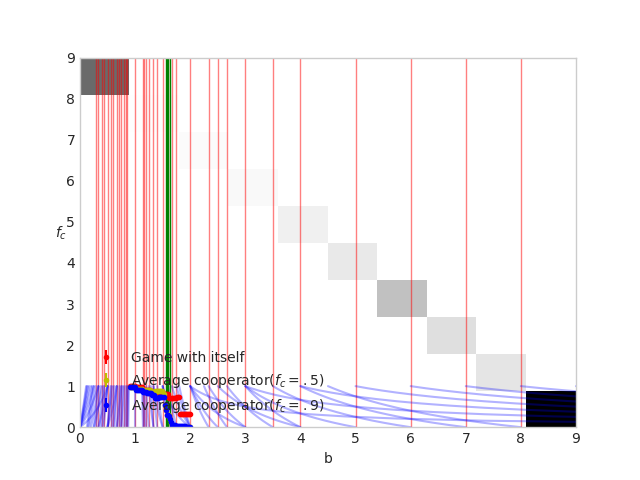

Text(0, 0.5, '$f_c$')

In [16]:
# fig = plt.figure()
plt.xlim(.9, 2)
# plt.suptitle('Средняя плотность кооператоров от $b$', fontsize=16)
plt.errorbar(bs, means_o, yerr=std_o, fmt=".r", label="Game with itself")
plt.errorbar(bs, means_n_5, yerr=std_n_5, fmt=".y", label="Average cooperator($f_c=.5$)")
plt.errorbar(bs, means_n, yerr=std_n, fmt=".b", label="Average cooperator($f_c=.9$)")
plt.legend(loc="lower left")
plt.xlabel("b")

for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")

# plt.plot((8+f_cs)/(5+f_cs), f_cs, '-b', alpha=.3)
plt.ylabel("$f_c$", rotation=0)

In [17]:
for x in [1.55517241, 1.57586207,
          1.60344828, 1.63793103]:
    plt.axvline(x=x, linewidth=1, color="g")

In [ ]:
1.6448 1.6517 1.6586 1.6655 1.6724 1.6793 1.6931

## Zooming into [1.5, 1.7]

In [5]:
np.linspace(1.5, 1.7, 30)

array([1.5       , 1.50689655, 1.5137931 , 1.52068966, 1.52758621,
       1.53448276, 1.54137931, 1.54827586, 1.55517241, 1.56206897,
       1.56896552, 1.57586207, 1.58275862, 1.58965517, 1.59655172,
       1.60344828, 1.61034483, 1.61724138, 1.62413793, 1.63103448,
       1.63793103, 1.64482759, 1.65172414, 1.65862069, 1.66551724,
       1.67241379, 1.67931034, 1.6862069 , 1.69310345, 1.7       ])

In [13]:
game = MeanGame(L, 1.6)
density2 = []
for b in tqdm(np.linspace(1.5, 1.7, 30)):
    den = []
    game.b = b
    for i in range(len(seeds)):
        d = []
        game.field = np.load("fields/field_{}_{}.npy".format(L, i) )
        game.evolve(CALC//2)
        game.evolve(CALC - CALC//2)
        den.append(game.densities[DROP::EVERY].tolist())
    density2.append(den)
    
np.save("data/density_of_cooperators15-17.npy", np.asarray(density2))

  0%|          | 0/30 [00:00<?, ?it/s]


NameError: name 'CALC' is not defined

In [20]:
density2 = np.load("data/density_of_cooperators15-17.npy")
density52 = np.load("data/density_of_cooperators515-17.npy")

In [21]:
density_new_wide = density2.mean(axis=-1)
density_new_5_wide = density52.mean(axis=-1)

std_n_w = density_new_wide.std(axis=-1)
std_n_5_w = density_new_5_wide.std(axis=-1)

means_n_w = density_new_wide.mean(axis=-1)
means_n_5_w = density_new_5_wide.mean(axis=-1)

In [22]:
density_new_wide = density2.mean(axis=-1)
density_new_5_wide = density52.mean(axis=-1)

std_n_w, std_n_5_w = [], []
means_n_w, means_n_5_w = [], []

for br in density_new_wide:
    m, d = mean_without_zeros(br)
    means_n_w.append(m)
    std_n_w.append(d)
    
for br in density_new_5_wide:
    m, d = mean_without_zeros(br)
    means_n_5_w.append(m)
    std_n_5_w.append(d)

In [23]:
den4_raw = np.load("data/density_for_400.npy")
den45_raw = np.load("data/density_for_400_5.npy")

den4 = den4_raw.mean(axis=-1)
std_4 = []
means_4 = []

for br in den4:
    m, d = mean_without_zeros(br)
    means_4.append(m)
    std_4.append(d)
    
den45 = den45_raw.mean(axis=-1)
std_45 = []
means_45 = []

for br in den45:
    m, d = mean_without_zeros(br)
    means_45.append(m)
    std_45.append(d)

In [ ]:
# fig = plt.figure()
plt.xlim(.9, 2)
# plt.suptitle('Средняя плотность кооператоров от $b$', fontsize=16)
plt.errorbar(bs, means_o, yerr=std_o, fmt="xr", label="The game with itself")

# plt.errorbar(bs[bs < 1.50001], means_n_5[bs < 1.50001], yerr=std_n_5[bs < 1.50001], fmt=".y", label="Average cooperator($f_0=.5$)")
# plt.errorbar(bs[bs > 1.6999], means_n_5[bs > 1.6999], yerr=std_n_5[bs > 1.6999], fmt=".y")
# plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_5_w, yerr=std_n_5_w, fmt=".y")

plt.errorbar(bs[bs < 1.50001], means_n[bs < 1.50001], yerr=std_n[bs < 1.50001], fmt=".b", label="Average cooperator")
plt.errorbar(bs[bs > 1.6999], means_n[bs > 1.6999], yerr=std_n[bs > 1.6999], fmt=".b")
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_w, yerr=std_n_w, fmt=".b")

# plt.errorbar([1.38474576, 1.5       , 1.54827586, 1.59655172,
#               1.62413793, 1.63103448, 1.7       , 1.92542373], means_4, yerr=std_4, fmt=".g")

# plt.errorbar([1.38474576, 1.5       , 1.54827586, 1.59655172,
#               1.62413793, 1.63103448, 1.7       , 1.92542373], means_45, yerr=std_45, fmt=".c")

# frame.set_edgecolor('blue')

for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.5)
plt.axvline(x=9/5., linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")

legend = plt.legend(loc="lower left", fontsize=14, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xlabel("b", fontsize=20)
plt.ylabel("$f_c$", rotation=0, fontsize=20)

<IPython.core.display.Javascript object>


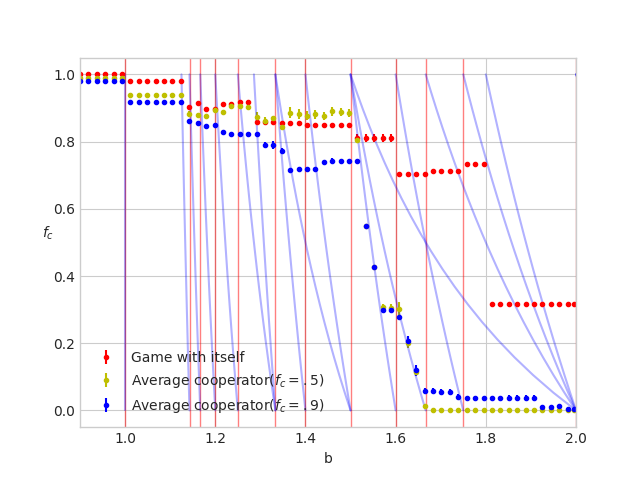

NameError: name 'means_o' is not defined

In [17]:
# fig = plt.figure()
plt.xlim(.9, 2)
# plt.suptitle('Средняя плотность кооператоров от $b$', fontsize=16)
plt.errorbar(bs, means_o, yerr=std_o, fmt="xr", label="Игра Новака-Мэя")

# plt.errorbar(bs[bs < 1.50001], means_n_5[bs < 1.50001], yerr=std_n_5[bs < 1.50001], fmt=".y", label="Average cooperator($f_0=.5$)")
# plt.errorbar(bs[bs > 1.6999], means_n_5[bs > 1.6999], yerr=std_n_5[bs > 1.6999], fmt=".y")
# plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_5_w, yerr=std_n_5_w, fmt=".y")

plt.errorbar(bs[bs < 1.50001], means_n[bs < 1.50001], yerr=std_n[bs < 1.50001], fmt=".b", label="Среднее поле")
plt.errorbar(bs[bs > 1.6999], means_n[bs > 1.6999], yerr=std_n[bs > 1.6999], fmt=".b")
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_w, yerr=std_n_w, fmt=".b")

# plt.errorbar([1.38474576, 1.5       , 1.54827586, 1.59655172,
#               1.62413793, 1.63103448, 1.7       , 1.92542373], means_4, yerr=std_4, fmt=".g")

# plt.errorbar([1.38474576, 1.5       , 1.54827586, 1.59655172,
#               1.62413793, 1.63103448, 1.7       , 1.92542373], means_45, yerr=std_45, fmt=".c")

# frame.set_edgecolor('blue')

for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.5)
plt.axvline(x=9/5., linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")

legend = plt.legend(loc="lower left", fontsize=14, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xlabel("b", fontsize=14)
plt.ylabel("$f_c$", rotation=0, fontsize=14)

In [22]:
plt.savefig("figures/cooperators_density_at_different_b_rus", dpi=500, quality=95)

<IPython.core.display.Javascript object>


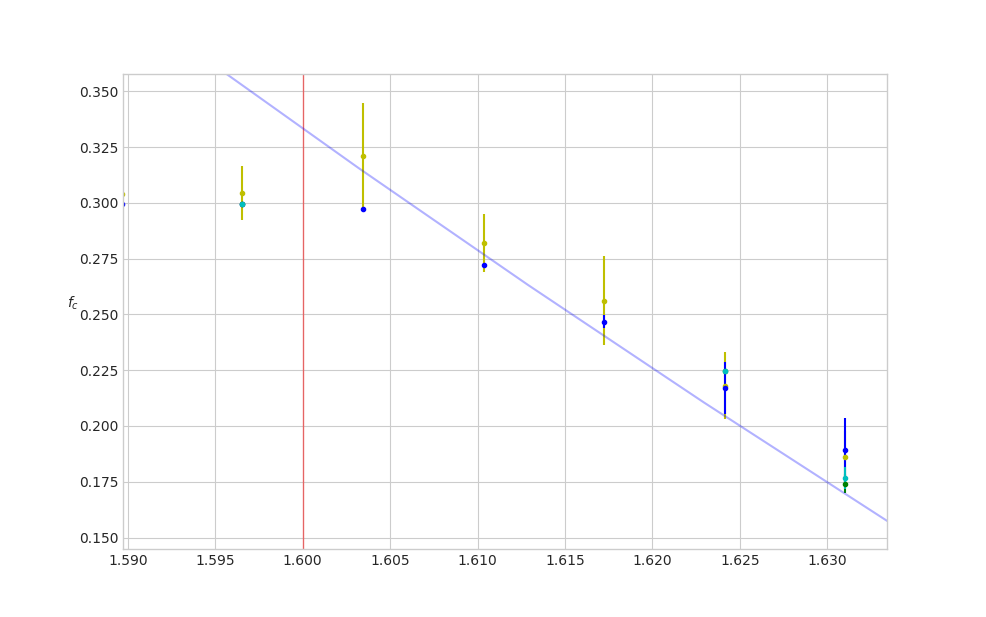

Text(0, 0.5, '$f_c$')

In [27]:
plt.xlim(1.495, 1.705)
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_5_w, yerr=std_n_5_w, fmt=".y", label="The game with average cooperator($f_0=.5$)")
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_w, yerr=std_n_w, fmt=".b", label="The game with average cooperator")
plt.errorbar([1.5, 1.54827586, 1.59655172, 1.62413793, 1.63103448, 1.7, 1.92542373], means_4[1:], yerr=std_4[1:], fmt=".g")
plt.errorbar([1.5       , 1.54827586, 1.59655172,
              1.62413793, 1.63103448, 1.7       , 1.92542373], means_45[1:], yerr=std_45[1:], fmt=".c")
for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")
# plt.plot((8+f_cs)/(5+f_cs), f_cs, '-b', alpha=.3)
plt.text(1.525, 0.2, "1", color='red', fontsize=15)
plt.text(1.61, 0.08, "2", color='red', fontsize=15)
plt.text(1.65, 0.2,  "3", color='red', fontsize=15)
plt.ylabel("$f_c$", rotation=0)

In [24]:
plt.savefig("figures/cooperators_density_at_different_b_wide", dpi=500, quality=95)

In [12]:
np.concatenate([bs[bs < 1.50001], np.linspace(1.5, 1.7, 30), bs[bs > 1.6999]])

array([0.9       , 0.91864407, 0.93728814, 0.9559322 , 0.97457627,
       0.99322034, 1.01186441, 1.03050847, 1.04915254, 1.06779661,
       1.08644068, 1.10508475, 1.12372881, 1.14237288, 1.16101695,
       1.17966102, 1.19830508, 1.21694915, 1.23559322, 1.25423729,
       1.27288136, 1.29152542, 1.31016949, 1.32881356, 1.34745763,
       1.36610169, 1.38474576, 1.40338983, 1.4220339 , 1.44067797,
       1.45932203, 1.4779661 , 1.49661017, 1.5       , 1.50689655,
       1.5137931 , 1.52068966, 1.52758621, 1.53448276, 1.54137931,
       1.54827586, 1.55517241, 1.56206897, 1.56896552, 1.57586207,
       1.58275862, 1.58965517, 1.59655172, 1.60344828, 1.61034483,
       1.61724138, 1.62413793, 1.63103448, 1.63793103, 1.64482759,
       1.65172414, 1.65862069, 1.66551724, 1.67241379, 1.67931034,
       1.6862069 , 1.69310345, 1.7       , 1.70169492, 1.72033898,
       1.73898305, 1.75762712, 1.77627119, 1.79491525, 1.81355932,
       1.83220339, 1.85084746, 1.86949153, 1.88813559, 1.90677

## Persistance

In [11]:
L = 200
game = MeanGame(L, 1.6)
persistance = []
for b in tqdm(np.concatenate([bs[bs < 1.50001], np.linspace(1.5, 1.7, 30), bs[bs > 1.6999]])):
    game.b = b
    game.field = np.load(f"fields/field_{L}_10.npy")
    game.evolve(5000)
    game.evolve(2500)
    currlivetime = np.ones_like(game.field)
    for i in range(2000):
        field = game.field.copy()
        game.evolve(1)
        currlivetime[(game.field + 2*(game.field-field)) == -2] = 0
        currlivetime[(game.field + 2*(game.field-field)) == 3] = 0
#         del field
        if currlivetime.sum() == 0:
            break
    persistance.append(currlivetime.sum()/(1.*currlivetime.shape[0]*currlivetime.shape[1]))

100%|██████████| 80/80 [1:21:26<00:00, 74.72s/it]


In [29]:
plt.plot(np.concatenate([bs[bs < 1.50001], np.linspace(1.5, 1.7, 30), bs[bs > 1.6999]]), persistance, "y", label="Persistance(P(t, 7500))")

<IPython.core.display.Javascript object>


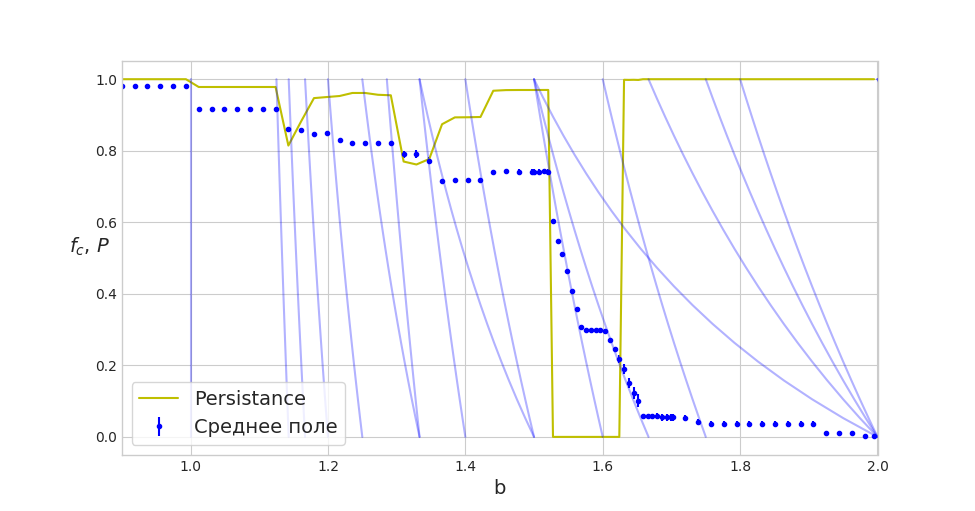

Text(0, 0.5, '$f_c$, $P$')

In [36]:
# fig = plt.figure()
plt.xlim(.9, 2)
# plt.suptitle('Средняя плотность кооператоров от $b$', fontsize=16)
# plt.errorbar(bs, means_o, yerr=std_o, fmt="xr", label="Игра Новака-Мэя")

# plt.errorbar(bs[bs < 1.50001], means_n_5[bs < 1.50001], yerr=std_n_5[bs < 1.50001], fmt=".y", label="Average cooperator($f_0=.5$)")
# plt.errorbar(bs[bs > 1.6999], means_n_5[bs > 1.6999], yerr=std_n_5[bs > 1.6999], fmt=".y")
# plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_5_w, yerr=std_n_5_w, fmt=".y")

plt.errorbar(bs[bs < 1.50001], means_n[bs < 1.50001], yerr=std_n[bs < 1.50001], fmt=".b", label="Среднее поле")
plt.errorbar(bs[bs > 1.6999], means_n[bs > 1.6999], yerr=std_n[bs > 1.6999], fmt=".b")
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_w, yerr=std_n_w, fmt=".b")

plt.plot(np.concatenate([bs[bs < 1.50001], np.linspace(1.5, 1.7, 30), bs[bs > 1.6999]]),
        persistance,
         "y", label="Persistance")

# plt.errorbar([1.38474576, 1.5       , 1.54827586, 1.59655172,
#               1.62413793, 1.63103448, 1.7       , 1.92542373], means_4, yerr=std_4, fmt=".g")

# plt.errorbar([1.38474576, 1.5       , 1.54827586, 1.59655172,
#               1.62413793, 1.63103448, 1.7       , 1.92542373], means_45, yerr=std_45, fmt=".c")

# frame.set_edgecolor('blue')

# for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
#     plt.axvline(x=x, linewidth=1, color='r', alpha=.5)
# plt.axvline(x=9/5., linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")

legend = plt.legend(loc="lower left", fontsize=14, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xlabel("b", fontsize=14)
plt.ylabel("$f_c$, $P$", rotation=0, fontsize=14)

In [39]:
plt.savefig("figures/density_and_persistance_mean_field.jpg", dpi=300, quality=95)

# Larger fields

In [11]:
bs2 = [1.1983, 1.4034, 1.5345, 1.5828, 1.6310, 1.8136]
bs3 = [1.6448, 1.6517, 1.6586, 1.6655, 1.6724, 1.6793, 1.6931]

In [12]:
density8 = np.load("data/densities800.npy")
mean8 = density8.mean(axis=-1).mean(axis=-1)
std8 = density8.mean(axis=-1).std(axis=-1)

density4 = np.load("data/densities400.npy")
mean4 = density4.mean(axis=-1).mean(axis=-1)
std4 = density4.mean(axis=-1).std(axis=-1)

densityrh = np.load("data/density_righthyperbola.npy")
meanrh = densityrh.mean(axis=-1).mean(axis=-1)
stdrh = densityrh.mean(axis=-1).std(axis=-1)

In [16]:
persistence800 = np.load("data/persistence800.npy").mean(axis=-1)
persistence400 = np.load("data/persistence400.npy").mean(axis=-1)
persistenceright = np.load("data/persistence_righthyperbola.npy").mean(axis=-1)

In [15]:
persistence400.shape

(6, 40)

<IPython.core.display.Javascript object>


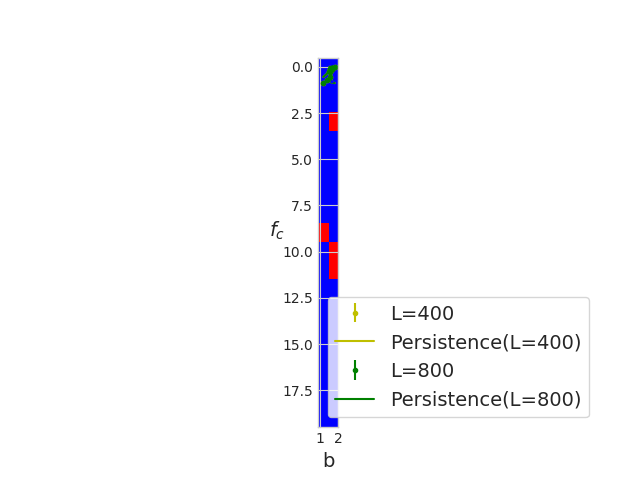

Text(0, 0.5, '$f_c$')

In [19]:
# fig = plt.figure()
plt.xlim(.9, 2)
# plt.suptitle('Средняя плотность кооператоров от $b$', fontsize=16)

# plt.errorbar(bs[bs < 1.50001], means_n[bs < 1.50001], yerr=std_n[bs < 1.50001], fmt=".b", alpha=.1, label="L=100")
# plt.errorbar(bs[bs > 1.6999], means_n[bs > 1.6999], yerr=std_n[bs > 1.6999], fmt=".b", alpha=.1)
# plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_w, yerr=std_n_w, fmt=".b", alpha=.1)

plt.errorbar(bs2, mean4, yerr=std4, fmt=".y", label="L=400")
plt.errorbar(bs2, persistence400, fmt="-y", label="Persistence(L=400)")
plt.errorbar(bs2, mean8[[0, 4, 2, 3, 1, 5]], yerr=std8[[0, 4, 2, 3, 1, 5]], fmt=".g", label="L=800")
plt.errorbar(bs2, persistence800[[0, 4, 2, 3, 1, 5]], fmt="-g", label="Persistence(L=800)")
plt.errorbar(bs3, meanrh, yerr=stdrh, fmt=".g")
plt.errorbar(bs3, persistenceright, fmt="-b")


legend = plt.legend(loc="lower left", fontsize=14, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xlabel("b", fontsize=14)
plt.ylabel("$f_c$", rotation=0, fontsize=14)

In [13]:
np.concatenate([bs[bs < 1.50001], np.linspace(1.5, 1.7, 30), bs[bs > 1.6999]])

array([0.9       , 0.91864407, 0.93728814, 0.9559322 , 0.97457627,
       0.99322034, 1.01186441, 1.03050847, 1.04915254, 1.06779661,
       1.08644068, 1.10508475, 1.12372881, 1.14237288, 1.16101695,
       1.17966102, 1.19830508, 1.21694915, 1.23559322, 1.25423729,
       1.27288136, 1.29152542, 1.31016949, 1.32881356, 1.34745763,
       1.36610169, 1.38474576, 1.40338983, 1.4220339 , 1.44067797,
       1.45932203, 1.4779661 , 1.49661017, 1.5       , 1.50689655,
       1.5137931 , 1.52068966, 1.52758621, 1.53448276, 1.54137931,
       1.54827586, 1.55517241, 1.56206897, 1.56896552, 1.57586207,
       1.58275862, 1.58965517, 1.59655172, 1.60344828, 1.61034483,
       1.61724138, 1.62413793, 1.63103448, 1.63793103, 1.64482759,
       1.65172414, 1.65862069, 1.66551724, 1.67241379, 1.67931034,
       1.6862069 , 1.69310345, 1.7       , 1.70169492, 1.72033898,
       1.73898305, 1.75762712, 1.77627119, 1.79491525, 1.81355932,
       1.83220339, 1.85084746, 1.86949153, 1.88813559, 1.90677

In [ ]:
[1.63103448, 1.63793103, 1.64482759, 1.65172414, 1.65862069, 1.66551724, 1.67241379, 1.67931034, 1.6862069 , 1.69310345]

In [3]:
[1.55517241, 1.57586207, 1.60344828, 1.63793103]

[1.55517241, 1.57586207, 1.60344828, 1.63793103]

In [53]:
b = 1.55
L = 100
game = MeanGame(L, b)
game.field = np.load("fields/field_100_10.npy")
game.evolve(8000)
game.evolve(2000)

<IPython.core.display.Javascript object>


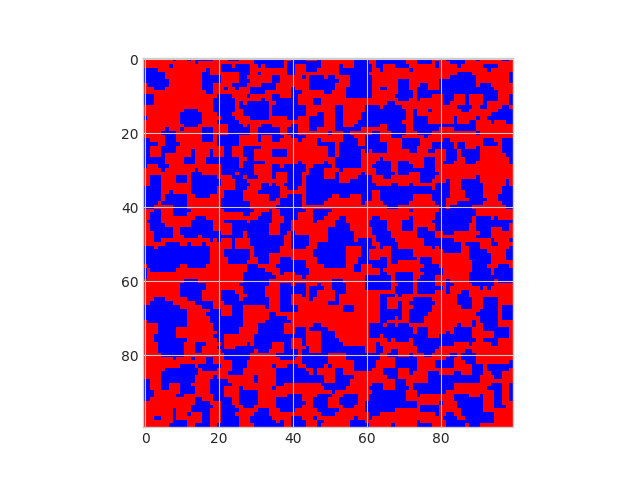

In [54]:
plt.imshow(make_rgb(game.field.astype("long")))

In [11]:
def calc_score(field, b):
    L = field.shape[0]
    f_c = np.sum(field)/(L*L)
    scores = np.zeros_like(field)
    for x in range(L):
        for y in range(L):
            x1, x2, x3 = (x-1)%L, x%L, (x+1)%L
            y1, y2, y3 = (y-1)%L, y%L, (y+1)%L
    #                 return ((x1, x2, x3), (y1, y2, y3))
            scores[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] +
                            field[x2, y1] + f_c + field[x2, y3] +
                            field[x3, y1] + field[x3, y2] + field[x3, y3])
            if field[x, y] == 0:
                scores[x, y] *= b
    return scores

In [38]:
def calc_n_m(b, L = 200, t=20):
    game = MeanGame(L, b)
    game.field = np.load(f"fields/field_{L}_{t}.npy")
    game.evolve(8000)
    game.evolve(2000)
    field = game.field
    score = calc_score(field, b)
    m_coop, m_def = np.zeros_like(field, dtype="int16")-1, np.zeros_like(field, dtype="int16")-1 # cooperators
    L = field.shape[0]
    for _ in range(10):
        for x in range(field.shape[0]):
            for y in range(field.shape[0]):
                m_d, m_c = -22, -22
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if field[(x+i)%L, (y+j)%L] == 0 and score[(x+i)%L, (y+j)%L] > m_d:
                            m_d = score[(x+i)%L, (y+j)%L]
                            x1, x2, x3 = (x+i-1)%L, (x+i)%L, (x+i+1)%L
                            y1, y2, y3 = (y+j-1)%L, (y+j)%L, (y+j+1)%L
                            m_def[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] +
                                    field[x2, y1] + field[x2, y3] +
                                    field[x3, y1] + field[x3, y2] + field[x3, y3])

                        if field[(x+i)%L, (y+j)%L] == 1 and score[(x+i)%L, (y+j)%L] > m_c:
                            m_c = score[(x+i)%L, (y+j)%L]
                            x1, x2, x3 = (x+i-1)%L, (x+i)%L, (x+i+1)%L
                            y1, y2, y3 = (y+j-1)%L, (y+j)%L, (y+j+1)%L
                            m_coop[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] +
                                    field[x2, y1] + field[x2, y3] +
                                    field[x3, y1] + field[x3, y2] + field[x3, y3])
        m_c += m_coop 
    return m_coop[(m_coop >= 0) & (m_def >= 0)].flatten(), m_def[(m_coop >= 0) & (m_def >= 0)].flatten()

In [14]:
def calc_n_m(field, b):
    score = calc_score(field, b)
    m_coop, m_def = np.zeros_like(field, dtype="int16")-1, np.zeros_like(field, dtype="int16")-1 # cooperators
    L = field.shape[0]
    
    for x in range(L):
        for y in range(L):
            m_d, m_c = -22, -22
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if field[(x+i)%L, (y+j)%L] == 0 and score[(x+i)%L, (y+j)%L] > m_d:
                        m_d = score[(x+i)%L, (y+j)%L]
                        x1, x2, x3 = (x+i-1)%L, (x+i)%L, (x+i+1)%L
                        y1, y2, y3 = (y+j-1)%L, (y+j)%L, (y+j+1)%L
                        m_def[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] +
                                field[x2, y1] + field[x2, y3] +
                                field[x3, y1] + field[x3, y2] + field[x3, y3])

                    if field[(x+i)%L, (y+j)%L] == 1 and score[(x+i)%L, (y+j)%L] > m_c:
                        m_c = score[(x+i)%L, (y+j)%L]
                        x1, x2, x3 = (x+i-1)%L, (x+i)%L, (x+i+1)%L
                        y1, y2, y3 = (y+j-1)%L, (y+j)%L, (y+j+1)%L
                        m_coop[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] +
                                field[x2, y1] + field[x2, y3] +
                                field[x3, y1] + field[x3, y2] + field[x3, y3])

    return m_coop[(m_coop >= 0) & (m_def >= 0)].flatten(), m_def[(m_coop >= 0) & (m_def >= 0)].flatten()

In [13]:
bs = [1.5       , 1.50689655, 1.5137931 , 1.52068966, 1.52758621,
      1.53448276, 1.54137931, 1.54827586, 1.55517241, 1.56206897,
      1.56896552, 1.57586207, 1.58275862, 1.58965517, 1.59655172,
      1.60344828, 1.61034483, 1.61724138, 1.62413793, 1.63103448,
      1.63793103, 1.64482759, 1.65172414, 1.65862069]

In [14]:
from tqdm import tqdm

In [23]:
m_coop, m_def = [], []
L = 200
for b in tqdm(bs):
    m_coopt, m_deft = [], []
    for t in [1, 15, 45]:
        game = MeanGame(L, b)
        game.field = np.load(f"fields/field_{L}_{t}.npy")
        game.evolve(6000)
        for _ in range(10):
            n, m = calc_n_m(game.field)
            game.evolve(1)
            m_coopt.extend(n)
            m_deft.extend(m)
    m_coop.append(m_coopt)
    m_def.append(m_deft)

100%|██████████| 24/24 [2:06:09<00:00, 317.05s/it]  


In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation

In [25]:
def animate(i):
    # simulate new data coming in
    data = np.random.randn(1000)
    n, bins = np.histogram(data, 100)
    top = bottom + n
    verts[1::5, 1] = top
    verts[2::5, 1] = top
    return [patch, ]

<IPython.core.display.Javascript object>


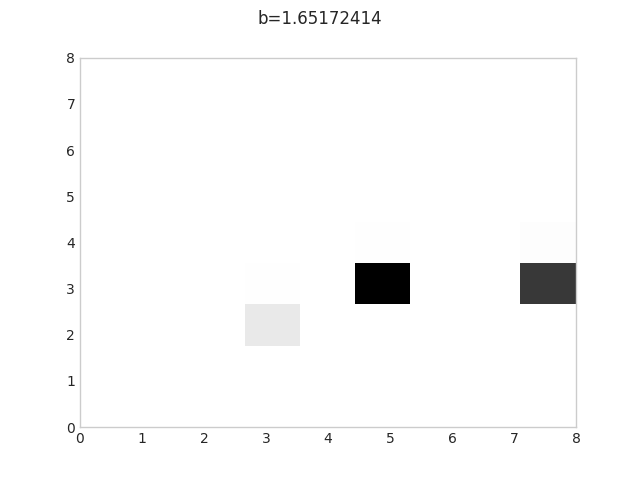

In [26]:
number_of_frames = 24

def update_hist(num, n, m, bs):
    plt.cla()
    plt.hist2d(n[num], m[num], range=[[0, 8],[0, 8]], bins=[9, 9])
    plt.suptitle(f"b={bs[num]}")
    plt.xlim((0, 8))
    plt.ylim((0, 8))
    

fig = plt.figure()
hist = plt.hist2d(m_coop[0], m_def[0], range=[[0, 8],[0, 8]], bins=[9, 9])
plt.xlim((0, 8))
plt.ylim((0, 8))

anim = animation.FuncAnimation(fig, update_hist, number_of_frames, interval=300, fargs=(m_coop, m_def, bs) )
anim.save("nmevolving200x200.mp4", dpi=300)
plt.show()